# Collaborative Filtering – Score-Only Model

This notebook begins the modeling phase of the beer recommender system by implementing a basic collaborative filtering approach based solely on user-item interactions, specifically the review `score`.

## Objective

The primary goal of this stage is to:
- Build a collaborative filtering model using **only user IDs and beer IDs**, along with their corresponding **review scores**.
- Evaluate how well a latent factor model can learn user preferences and item characteristics using **implicit patterns in rating behavior**.
- Establish a baseline model to be enhanced in future iterations with additional beer metadata (e.g., ABV, style, availability) for hybrid recommendations.

## Methodology

- Construct a **user-beer matrix** from the cleaned review data.
- Train a **matrix factorization model** (e.g., using PyTorch or an embedding-based MLP).
- Evaluate the model using metrics such as RMSE and top-k recommendation quality.

This foundational model serves as a benchmark against which hybrid models incorporating beer content features will be compared in later notebooks.


---

In [4]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA device found")


# Loading Dataset

import pandas as pd

try:
    df = pd.read_csv('final_beers_reviews_breweries.csv')
except Exception as e:
    print(f"Error loading reviews.csv: {e}")

CUDA available: True
Device name: NVIDIA GeForce RTX 3080


---

### Feature Normalization

To prepare the rating-related attributes for collaborative filtering models, the following review features were scaled to a [0, 1] range using **MinMax normalization**:
- `look`
- `smell`
- `taste`
- `feel`
- `overall`
- `score`

This normalization ensures that all rating dimensions contribute equally during training, preventing attributes with larger original scales from disproportionately influencing the learning process.

#### Post-Normalization Summary:
- All normalized features have a **minimum of 0.0** and a **maximum of 1.0**.
- The distribution remains centered around **0.75**, reflecting the original skew of the review scores toward higher ratings.

This step sets a consistent numerical foundation for training latent factor models such as matrix factorization or embedding-based recommenders.


In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[['look', 'smell', 'taste', 'feel', 'overall', 'score']] = scaler.fit_transform(
    df[[ 'look', 'smell', 'taste', 'feel', 'overall', 'score']]
)
df.describe()

abv        beer_id           look          smell  \
count  614525.000000  614525.000000  614525.000000  614525.000000   
mean        7.582153   13682.230450       0.754612       0.736018   
std         2.353999   20065.492805       0.142259       0.159482   
min         2.500000       6.000000       0.000000       0.000000   
25%         5.600000     689.000000       0.687500       0.625000   
50%         7.200000    2137.000000       0.750000       0.750000   
75%         9.100000   21300.000000       0.875000       0.875000   
max        18.000000  148052.000000       1.000000       1.000000   

               taste           feel        overall          score  
count  614525.000000  614525.000000  614525.000000  614525.000000  
mean        0.755178       0.738499       0.751018       0.748170  
std         0.163359       0.155050       0.158492       0.140153  
min         0.000000       0.000000       0.000000       0.000000  
25%         0.687500       0.625000       0.687500       0.687500  
50%         0.750000       0.750000       0.750000       0.770000  
75%         0.875000       0.875000       0.875000       0.837500  
max         1.000000       1.000000       1.000000       1.000000

### User and Item Index Mapping

To prepare the dataset for collaborative filtering with matrix-based models, each unique user and beer was assigned a numeric index:

- **User Mapping**: `username` values were mapped to a new `userIndex` column using a unique integer for each user.
- **Beer Mapping**: `beer_id` values were mapped to a `beerIndex` column similarly.

This indexing allows for efficient embedding lookup during model training.

- **Unique Users**: 15,894
- **Unique Beers**: 500  
  *(Note: This aligns with the earlier filtering to include only the top 500 most-reviewed beers.)*

### Train-Validation Split

The dataset was randomly split into:
- **Training Set**: 80% (491,620 rows)
- **Validation Set**: 20% (122,905 rows)

This split enables model training and unbiased evaluation on held-out data before proceeding to test or production deployment.


In [6]:
from sklearn.model_selection import train_test_split

# Create mapping dictionaries for users and beers
users = df['username'].unique()
userIndexMap = {user: idx for idx, user in enumerate(users)}

beers = df['beer_id'].unique()
beerIndexMap = {beer: idx for idx, beer in enumerate(beers)}

# Map the original columns to new index columns
df['userIndex'] = df['username'].map(userIndexMap)
df['beerIndex'] = df['beer_id'].map(beerIndexMap)

print("Number of unique users:", len(userIndexMap))
print("Number of unique beers:", len(beerIndexMap))

Number of unique users: 15894
Number of unique beers: 500


In [7]:
# Split the data (e.g., 80% training, 20% validation)
trainDf, valDf = train_test_split(df, test_size=0.2, random_state=42)

print("Training set shape:", trainDf.shape)
print("Validation set shape:", valDf.shape)


Training set shape: (491620, 23)
Validation set shape: (122905, 23)


---

### PyTorch Dataset and DataLoader Preparation

To enable efficient training of the collaborative filtering model in PyTorch, a custom dataset class `BeerDataset` was implemented. This class wraps the training and validation DataFrames and provides:

- **user**: Encoded user index (`userIndex`)
- **beer**: Encoded item index (`beerIndex`)
- **score**: Normalized review score as the target

Each sample is returned as a dictionary containing tensors for user, beer, and score, making it suitable for mini-batch training.

#### DataLoaders
The dataset is loaded into PyTorch `DataLoader`s:
- **Training Loader** (`trainLoader`): Uses a batch size of 256 and shuffling enabled to randomize batches during training.
- **Validation Loader** (`valLoader`): Uses the same batch size but no shuffling, preserving the order for evaluation.

These components prepare the dataset for input into an embedding-based collaborative filtering model that will learn latent user and beer representations from the interaction data.


In [8]:
import torch
from torch.utils.data import Dataset

class BeerDataset(Dataset):
    def __init__(self, df):
        self.user_ids = df['userIndex'].values
        self.beer_ids = df['beerIndex'].values
        self.scores = df['score'].values.astype('float32')
    
    def __len__(self):
        return len(self.scores)
    
    def __getitem__(self, idx):
        return {
            'user': torch.tensor(self.user_ids[idx], dtype=torch.long),
            'beer': torch.tensor(self.beer_ids[idx], dtype=torch.long),
            'score': torch.tensor(self.scores[idx], dtype=torch.float)
        }

trainDataset = BeerDataset(trainDf)
valDataset = BeerDataset(valDf)


In [9]:
from torch.utils.data import DataLoader

trainLoader = DataLoader(trainDataset, batch_size=256, shuffle=True)
valLoader = DataLoader(valDataset, batch_size=256, shuffle=False)


### Model Architecture – Score-Only Recommender

The collaborative filtering model is implemented using a neural network architecture that leverages **user and item embeddings** to learn latent preferences and item characteristics.

#### Key Components:

- **Embedding Layers**:
  - `user_embedding`: Learns a dense vector for each user.
  - `beer_embedding`: Learns a dense vector for each beer.
  
- **Bias Terms**:
  - `user_bias` and `beer_bias`: Capture individual user and beer bias.
  - `global_bias`: A learnable scalar capturing the overall average rating tendency.

- **Multi-Layer Perceptron (MLP)**:
  - Concatenates the user and beer embeddings.
  - Passes the combined vector through two fully connected layers with ReLU activation to capture non-linear interactions.
  - Outputs a base prediction (`base_pred`) for the rating.

- **Final Prediction**:
  \[
  \hat{r}_{u,i} = \text{base\_pred} + b_u + b_i + b
  \]
  Where:
  - \( \hat{r}_{u,i} \) is the predicted rating for user *u* and beer *i*
  - \( b_u \), \( b_i \), and \( b \) are the user, item, and global biases, respectively

#### Optimization:

- **Loss Function**: Mean Squared Error (MSE) is used to penalize differences between predicted and actual scores.
- **Optimizer**: Adam optimizer is employed with a learning rate of **0.0025**.

The model is designed to run on GPU if available, ensuring faster training on large datasets. This architecture serves as the baseline for later enhancements that incorporate beer metadata (e.g., style, ABV) into the recommendation process.


In [10]:
import torch.nn as nn

class Recommender(nn.Module):
    def __init__(self, num_users, num_beers, embedding_dim=32):
        super(Recommender, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.beer_embedding = nn.Embedding(num_beers, embedding_dim)
        
        #insert bias terms
        self.user_bias = nn.Embedding(num_users, 1)
        self.beer_bias = nn.Embedding(num_beers, 1)
        self.global_bias = nn.Parameter(torch.tensor([0.0]))

        #MLP for combined embeddings
        self.fc_layers = nn.Sequential(
            nn.Linear(embedding_dim * 2, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    
    def forward(self, user, beer):
        user_emb = self.user_embedding(user)   # Shape: (batch_size, embedding_dim)
        beer_emb = self.beer_embedding(beer)     # Shape: (batch_size, embedding_dim)
        # Dot product of the embeddings gives a predicted rating
        #rating = (user_emb * beer_emb).sum(dim=1)

        #Concatenate the embeddings for MLP
        x = torch.cat([user_emb, beer_emb], dim=1)

        #Predict base scare using MLP
        base_pred = self.fc_layers(x).squeeze()
        
        #modify the forward method
        
        user_b = self.user_bias(user).squeeze() #insert bias contributions
        beer_b = self.beer_bias(beer).squeeze()
        
        rating = base_pred + user_b + beer_b + self.global_bias #global bias + user bias + self.global_bias

        return rating

# Initialize model parameters
userCount = len(userIndexMap)
beerCount = len(beerIndexMap)
model = Recommender(userCount, beerCount, embedding_dim=32)


In [11]:
# to use GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


---

### Model Training

The recommender model was trained over **30 epochs** using the **Adam optimizer** and **Mean Squared Error (MSE)** as the loss function. Each mini-batch contained 256 samples drawn from the training set.

#### Training Configuration:
- **Optimizer**: Adam
- **Learning Rate**: 0.0025 (heuristically chosen)
- **Loss Function**: MSELoss
- **Epochs**: 30
- **Batch Size**: 256
- **Hardware**: GPU-accelerated (if available)

#### Observations:
- Initial loss started at approximately **0.37**, quickly converging below **0.02** within a few epochs.
- Final epoch loss reached approximately **0.0113**, indicating strong convergence.
- The training loss curve shows a consistent downward trend, demonstrating effective learning without overfitting during the training phase.


In [12]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0025) # arbritary selection of lr


Epoch 1/30, Loss: 0.3695
Epoch 2/30, Loss: 0.0362
Epoch 3/30, Loss: 0.0213
Epoch 4/30, Loss: 0.0182
Epoch 5/30, Loss: 0.0167
Epoch 6/30, Loss: 0.0157
Epoch 7/30, Loss: 0.0151
Epoch 8/30, Loss: 0.0146
Epoch 9/30, Loss: 0.0141
Epoch 10/30, Loss: 0.0139
Epoch 11/30, Loss: 0.0136
Epoch 12/30, Loss: 0.0134
Epoch 13/30, Loss: 0.0132
Epoch 14/30, Loss: 0.0130
Epoch 15/30, Loss: 0.0128
Epoch 16/30, Loss: 0.0127
Epoch 17/30, Loss: 0.0126
Epoch 18/30, Loss: 0.0125
Epoch 19/30, Loss: 0.0124
Epoch 20/30, Loss: 0.0123
Epoch 21/30, Loss: 0.0121
Epoch 22/30, Loss: 0.0120
Epoch 23/30, Loss: 0.0119
Epoch 24/30, Loss: 0.0119
Epoch 25/30, Loss: 0.0118
Epoch 26/30, Loss: 0.0117
Epoch 27/30, Loss: 0.0116
Epoch 28/30, Loss: 0.0115
Epoch 29/30, Loss: 0.0114
Epoch 30/30, Loss: 0.0113


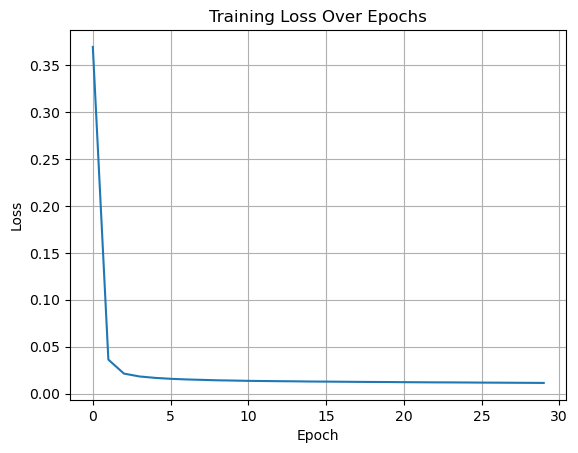

In [13]:
numEpochs = 30  # Adjust as needed
losses = [] # To store avg loss per epoch

for epoch in range(numEpochs):
    model.train()
    totalLoss = 0.0
    for batch in trainLoader:
        user = batch['user'].to(device)
        beer = batch['beer'].to(device)
        rating = batch['score'].to(device)

        optimizer.zero_grad()
        predictions = model(user, beer)
        loss = criterion(predictions, rating)
        loss.backward()
        optimizer.step()
        
        totalLoss += loss.item()
    
    avgLoss = totalLoss / len(trainLoader)
    losses.append(avgLoss)
    print(f"Epoch {epoch+1}/{numEpochs}, Loss: {avgLoss:.4f}")

#for visualising the losses
import matplotlib.pyplot as plt

plt.plot(losses)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


### Model Evaluation on Validation Set

After training, the model was evaluated on the held-out **validation set** using the same MSE loss function. Evaluation was done in inference mode using `torch.no_grad()` to disable gradient computation and improve performance.

#### Metrics:
- **Mean Squared Error (MSE)**: Average of the squared differences between predicted and actual ratings.
- **Root Mean Squared Error (RMSE)**: Square root of MSE, often used for interpretability in the original rating scale.

#### Results:
- **Validation MSE**: 0.0136
- **Validation RMSE**: 0.1168

These values suggest that the model is able to generalize well beyond the training data, with an average prediction error of ~0.117 on the normalized [0, 1] rating scale. This score-only collaborative filtering model now serves as a strong baseline before incorporating content features


In [15]:
model.eval()  # Set model to evaluation mode
totalValLoss = 0.0

# with torch.no_grad():
#     for batch in valLoader:
#         user = batch['user']
#         beer = batch['beer']
#         rating = batch['score']

with torch.no_grad():
    for batch in valLoader:
        user = batch['user'].to(device)
        beer = batch['beer'].to(device)
        rating = batch['score'].to(device)

        predictions = model(user, beer)
        loss = criterion(predictions, rating)  # MSE loss
        # Multiply by batch size to sum up total loss over the dataset
        totalValLoss += loss.item() * rating.size(0)

# Compute average MSE loss over the entire validation set
avgValLoss = totalValLoss / len(valDataset)
# RMSE is the square root of the MSE
rmse = avgValLoss ** 0.5

print(f"Validation MSE: {avgValLoss:.4f}")
print(f"Validation RMSE: {rmse:.4f}")

Validation MSE: 0.0136
Validation RMSE: 0.1168


## Recommendation Utilities and Real vs Predicted Preferences

This section establishes utility functions to interpret and evaluate the outputs of the trained collaborative filtering model, particularly for generating beer recommendations and validating them against real user preferences.

---

### Index Mappings

Before making predictions or retrieving results, internal user and beer indices must be mapped back to their original forms:
```python
indexBeerDict = {index: beer for beer, index in beerIndexMap.items()}
indexUserMap = {index: user for user, index in userIndexMap.items()}
getUsername = lambda userIndex: indexUserMap.get(userIndex, "Unknown User")


In [18]:
# utility functions and datafames

# inverse mappings
indexBeerDict = {index: beer for beer, index in beerIndexMap.items()}
indexUserMap = {index: user for user, index in userIndexMap.items()}

getUsername = lambda userIndex: indexUserMap.get(userIndex, "Unknown User")

def topKRecommendedBeersForUser(model, userIndex, topK=10):
    
    model.to(device)
    model.eval()
    
    # Tensor for all beer indices
    allBeerIndices = torch.arange(len(beerIndexDict)).to(device)

    # Tensor for users repeated for all beers
    userTensor = torch.tensor([userIndex] * len(beerIndexDict), dtype=torch.long).to(device)
    
    # Get predictions for all beers for this user
    with torch.no_grad():
        predictedRatings = model(userTensor, allBeerIndices)

    topRatings, topBeerIndices = torch.topk(predictedRatings, topK)

    # Map the indices back to beer identifiers or names using indexBeerDict
    recommendedBeers = [indexBeerDict[index.item()] for index in topBeerIndices]
    
    return recommendedBeers
    
beerDetails = df.groupby('beer_id').agg({
    'name': 'first',
    'state': 'first',
    'country': 'first',
    'style': 'first',
    'availability': 'first',
    'abv': 'mean',
    'notes': 'first',
    'look': 'mean',
    'smell': 'mean',
    'taste': 'mean',
    'feel': 'mean',
    'overall': 'mean',
    'score': 'mean',
    'name_brewery': 'first',
    'city': 'first',
    'notes_brewery': 'first',
    'types': 'first'
}).reset_index()

def getBeerDetailsFromIds(beerIdList):
    df_idx = beerDetails.set_index('beer_id')
    df_out = df_idx.loc[beerIdList]
    return df_out.reset_index()

def getActualTopKReviewedBeersForUser(username,topK=10):
    userReviews = df[df['username'] == username]
    return userReviews.sort_values(by='score', ascending=False).head(topK)


In [19]:
# For a given user index get the actual top K reviewed beers:
userIndex = 8180
username = getUsername(userIndex)
topK = 5
print(f"Username for user index {10}: {username}")
getActualTopKReviewedBeersForUser(username, topK)

Username for user index 10: 86MonteSS


name          state country  \
388790  Trappistes Rochefort 10          Namur      BE   
390655   Trappistes Rochefort 8          Namur      BE   
412661                   Abt 12  West Flanders      BE   
491497            Golden Monkey             PA      US   
369872           Imperial Stout            GB2      GB   

                           style availability   abv  \
388790  Belgian Quadrupel (Quad)   Year-round  11.3   
390655   Belgian Strong Dark Ale   Year-round   9.2   
412661  Belgian Quadrupel (Quad)   Year-round  10.0   
491497            Belgian Tripel   Year-round   9.5   
369872    Russian Imperial Stout   Year-round   7.0   

                                                    notes  beer_id   username  \
388790                             No notes at this time.      645  86MonteSS   
390655                             No notes at this time.     1696  86MonteSS   
412661                             No notes at this time.     1708  86MonteSS   
491497  A magical, mystical Monkey whose golden sole g...     1003  86MonteSS   
369872                             No notes at this time.      782  86MonteSS   

              date  ...  taste   feel  overall   score  \
388790  2003-04-21  ...  1.000  0.875    1.000  0.9800   
390655  2003-05-16  ...  1.000  0.875    1.000  0.9800   
412661  2003-11-06  ...  0.875  0.875    1.000  0.9375   
491497  2003-10-07  ...  1.000  1.000    1.000  0.9250   
369872  2003-04-21  ...  0.875  1.000    0.875  0.9250   

                                 name_brewery         city  \
388790                 Brasserie de Rochefort    Rochefort   
390655                 Brasserie de Rochefort    Rochefort   
412661             Brouwerij St. Bernardus NV        Watou   
491497  Victory Brewing Company - Downingtown  Downingtown   
369872   Samuel Smith Old Brewery (Tadcaster)    Tadcaster   

                 notes_brewery                             types userIndex  \
388790  No notes at this time.                           Brewery      8180   
390655  No notes at this time.                           Brewery      8180   
412661  No notes at this time.                           Brewery      8180   
491497  No notes at this time.  Brewery, Bar, Eatery, Beer-to-go      8180   
369872  No notes at this time.               Brewery, Beer-to-go      8180   

       beerIndex  
388790       307  
390655       308  
412661       324  
491497       389  
369872       291  

[5 rows x 23 columns]

### 📌 Insights

- **Preference Profile**: The selected user (`86MonteSS`) consistently gives high ratings to strong, dark, and often Belgian-style beers such as Trappistes Rochefort 10 and Abt 12. This highlights a preference for high-ABV, full-bodied, and complex beers.

- **Consistency in Taste**: All top-rated beers fall into either the Quadrupel, Tripel, or Imperial Stout categories, suggesting that taste preferences remain stable across styles that share richness, depth, and higher alcohol content.

- **Metadata Utility**: The ability to aggregate and query detailed beer metadata enables clear interpretation of what the model is recommending and why. This provides transparency and supports explainability in the recommendation process.

- **Validation Readiness**: These utilities allow for real-time comparison between model-generated recommendations and a user's historical top ratings. Such comparison is critical for iterative improvement of the recommender system.

- **Future Direction**: Insights from user behavior and rating trends can be used to guide enhancements in hybrid models—for example, by integrating beer features like style and ABV directly into the model architecture for personalized embeddings.

- **Model Explainability**: This framework bridges machine-generated predictions and human-readable outputs, an essential component for user trust and system transparency in real-world recommender applications.


---

### Conclusion: Vanilla Collaborative Filtering Model

The initial collaborative filtering model, which uses only user and beer IDs along with learned embeddings and biases, demonstrated strong baseline performance in predicting beer ratings. The training process showed a consistent reduction in loss over 30 epochs, and the model achieved a low RMSE of **0.1168** on the validation set—indicative of high predictive accuracy.

Key strengths of the model include:
- **Effective personalization** through embedding layers for both users and beers.
- **Bias incorporation** at user, item, and global levels to capture rating tendencies.
- **Scalable architecture** suitable for large datasets.

However, the model has several limitations:
- It **does not leverage content-based features** such as beer style, ABV, or textual reviews, which could enhance recommendations especially for new or sparsely rated items.
- **Cold-start users or items** (those with few or no ratings) may receive poor recommendations due to lack of interaction history.
- The model lacks interpretability and explainability, making it harder to justify predictions to end users.

This vanilla model provides a solid foundation for collaborative filtering. In the next phase, we aim to incorporate **beer content features** into the model architecture to create a hybrid recommender system that can deliver even more accurate and robust recommendations across a wider range of users and items.
